In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import coordinates as coords
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Galactic
import astropy.units as u
import dunestyle.matplotlib as dunestyle

/home/leoperes/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


DUNE plot style enabled


In [3]:
# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)

# Grid
n_pix = 100
l_vals = np.linspace(-180, 180, n_pix)
b_vals = np.linspace(-90, 90, n_pix // 2)
L, B = np.meshgrid(l_vals, b_vals)

# Compute LOS integral
print("Computing LOS integrals...")
rho_proj = np.zeros_like(L)
Alt = np.zeros_like(L)
Azimuth = np.zeros_like(L)
for i in range(B.shape[0]):
    for j in range(L.shape[1]):
        rho_proj[i, j] = los_integral(L[i, j], B[i, j])

# Convert to radians
L_rad = np.radians(L)
B_rad = np.radians(B)
L_rad = np.where(L_rad > np.pi, L_rad - 2*np.pi, L_rad)

Computing LOS integrals...


In [4]:
# --- DUNE location
dune_location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)

# --- Time samples (one year span, 100 samples)
current_time = Time.now() + 10 * u.year
end_time = current_time + 1 * u.year

N_skies = 3*360 # Number of sampled skies in one year - 3 per day

times = Time(np.linspace(current_time.jd, end_time.jd, N_skies), format='jd')

# --- Alt-Az binning
n_alt_bins = 90
n_az_bins = 180
alt_edges = np.linspace(-90, 90, n_alt_bins + 1)
az_edges = np.linspace(0, 360, n_az_bins + 1)

# Centers
alt_centers = 0.5 * (alt_edges[:-1] + alt_edges[1:])
az_centers = 0.5 * (az_edges[:-1] + az_edges[1:])
ALT, AZ = np.meshgrid(alt_centers, az_centers)

ALT_flat = ALT.flatten()
AZ_flat = AZ.flatten()

# --- Initialize arrays
intensity_time_all = np.zeros((len(times), len(ALT_flat)))  # (n_times, n_bins)

gc_pos = []

# --- Calculate
for idx_time, t in enumerate(times):
    # Galactic center coordinates
    gc_gal = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    gc_altaz = gc_gal.transform_to(AltAz(obstime=t, location=dune_location))
    
    gc_pos.append((gc_altaz.az.rad, gc_altaz.alt.rad))
    
    # Compute Galactic coordinates for all AltAz at this time
    altaz = AltAz(alt=ALT_flat*u.deg, az=AZ_flat*u.deg, location=dune_location, obstime=t)
    gal = altaz.transform_to(Galactic())
    
    l_rad = gal.l.deg
    b_rad = gal.b.deg

    # Calculate LOS integral for each point
    for idx_bin in range(len(ALT_flat)):
        intensity_time_all[idx_time, idx_bin] = los_integral(l_rad[idx_bin], b_rad[idx_bin])

gc_pos = np.array(gc_pos)

# --- Now: for each bin, summarize over time
#intensity_median = np.median(intensity_time_all, axis=0)
intensity_sum = np.sum(intensity_time_all, axis=0)

intensity_sum_median = intensity_sum / N_skies

# --- Normalize
intensity_sum_median_norm = intensity_sum_median / np.max(intensity_sum_median)
intensity_sum_norm = intensity_sum / np.max(intensity_sum)

/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


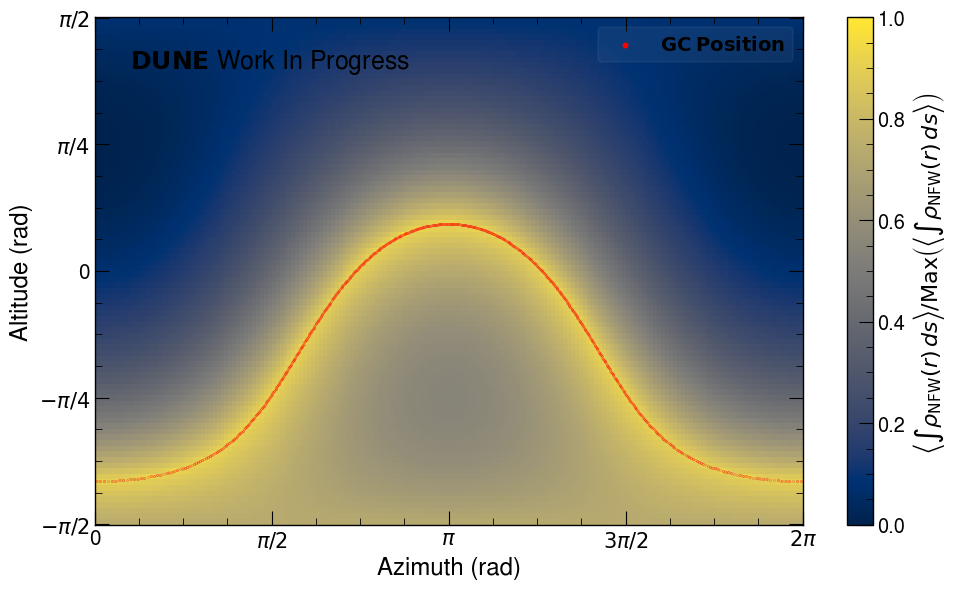

In [5]:
# Plot sum map
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
dunestyle.WIP(x=0.05, y=0.9)
ax.set_xticks([0.0,1.570,3.14159,4.7123,6.283])
ax.set_xticklabels([0,r'$\pi / 2$', r'$\pi$',r'$3\pi/2$', r'$2\pi$'], fontsize = 15)
ax.set_yticks([-1.570,-0.78539,0.0,0.78539,1.570])
ax.set_yticklabels([ r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$'], fontsize = 15)
plt.hist2d(np.radians(AZ_flat), np.radians(ALT_flat), weights=intensity_sum_norm,
           bins=[np.radians(az_edges), np.radians(alt_edges)])
gc_scatter = plt.scatter(gc_pos[:,0],gc_pos[:,1], marker='.', color='red', label = r'$\bf{GC\;Position}$', s =0.1)
cbar = plt.colorbar()
cbar.set_label(r'$ \left<\int \rho_\mathrm{NFW}(r)\,ds\right> /\text{Max}\left(\left<\int \rho_\mathrm{NFW}(r)\,ds\right>\right)$ ', fontsize=16)
plt.xlabel('Azimuth (rad)')
plt.ylabel('Altitude (rad)')

lgnd = plt.legend(handles=[gc_scatter],fontsize=14, frameon=True, framealpha=0.05)

# Fix marker size using the handles returned by legend
for handle in lgnd.legend_handles:
    handle.set_sizes([30])  # marker size in points²

plt.tight_layout()
plt.show()

In [6]:
# Save arrays to .npy files
np.save("az.npy", AZ_flat)
np.save("alt.npy", ALT_flat)
np.save("intensity_sum_norm.npy", intensity_sum_norm)  

In [5]:
def angular_distance(alt1, az1, alt2, az2):
    alt1, az1, alt2, az2 = map(np.radians, [alt1, az1, alt2, az2])
    return np.degrees(np.arccos(
        np.sin(alt1)*np.sin(alt2) + np.cos(alt1)*np.cos(alt2)*np.cos(az1 - az2)
    ))

cones_angle = np.linspace(5,180,36)

for cone in cones_angle:
    gc_fractions = []
    for i, t in enumerate(times):
        gc_altaz = gc_gal.transform_to(AltAz(obstime=t, location=dune_location))
        alt_gc = gc_altaz.alt.deg
        az_gc = gc_altaz.az.deg

        theta_deg = angular_distance(ALT_flat, AZ_flat, alt_gc, az_gc)
        mask_gc = theta_deg < cone   

        intensity_t = intensity_time_all[i]
        f_gc = intensity_t[mask_gc].sum() / intensity_t.sum()
        gc_fractions.append(f_gc)

    avg_fraction_gc = np.mean(gc_fractions)
    print(f"Average GC-aligned fraction (θ < {cone}°): {avg_fraction_gc:.5f}")

/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Average GC-aligned fraction (θ < 5.0°): 0.01069
Average GC-aligned fraction (θ < 10.0°): 0.03393
Average GC-aligned fraction (θ < 15.0°): 0.06618
Average GC-aligned fraction (θ < 20.0°): 0.10632
Average GC-aligned fraction (θ < 25.0°): 0.14853
Average GC-aligned fraction (θ < 30.0°): 0.19161
Average GC-aligned fraction (θ < 35.0°): 0.23510
Average GC-aligned fraction (θ < 40.0°): 0.27843
Average GC-aligned fraction (θ < 45.0°): 0.32155
Average GC-aligned fraction (θ < 50.0°): 0.36410
Average GC-aligned fraction (θ < 55.0°): 0.40619
Average GC-aligned fraction (θ < 60.0°): 0.44767
Average GC-aligned fraction (θ < 65.0°): 0.48884
Average GC-aligned fraction (θ < 70.0°): 0.52986
Average GC-aligned fraction (θ < 75.0°): 0.57220
Average GC-aligned fraction (θ < 80.0°): 0.61400
Average GC-aligned fraction (θ < 85.0°): 0.65377
Average GC-aligned fraction (θ < 90.0°): 0.69155
Average GC-aligned fraction (θ < 95.0°): 0.72738
Average GC-aligned fraction (θ < 100.0°): 0.76129
Average GC-aligned f

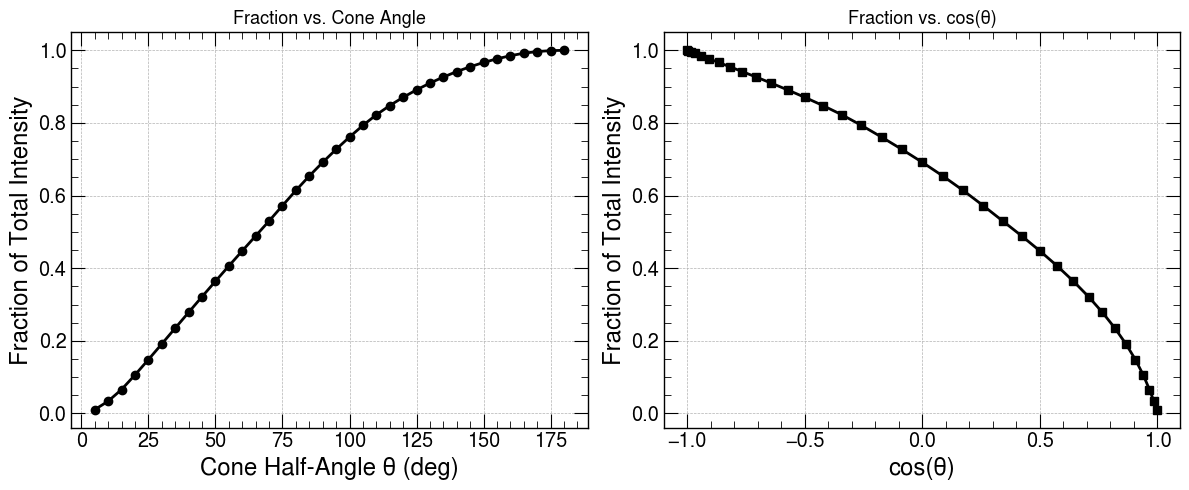

In [6]:

# Provided data
angles = np.arange(5, 181, 5)
fractions = np.array([
    0.01066, 0.03389, 0.06605, 0.10610, 0.14833, 0.19146, 0.23500, 0.27836,
    0.32150, 0.36408, 0.40616, 0.44769, 0.48888, 0.52996, 0.57231, 0.61413,
    0.65387, 0.69155, 0.72729, 0.76117, 0.79322, 0.82240, 0.84777, 0.87057,
    0.89111, 0.90969, 0.92641, 0.94142, 0.95473, 0.96646, 0.97657, 0.98510,
    0.99196, 0.99653, 0.99914, 1.00000
])

# Plot: angle vs. fraction
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(angles, fractions, marker='o')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel("Fraction of Total Intensity")
plt.title("Fraction vs. Cone Angle", fontsize=13)
plt.grid(True)

# Plot: cos(theta) vs. fraction
plt.subplot(1, 2, 2)
cos_theta = np.cos(np.radians(angles))
plt.plot(cos_theta, fractions, marker='s')
plt.xlabel("cos(θ)")
plt.ylabel("Fraction of Total Intensity")
plt.title("Fraction vs. cos(θ)", fontsize=13)
plt.grid(True)

plt.tight_layout()
plt.show()

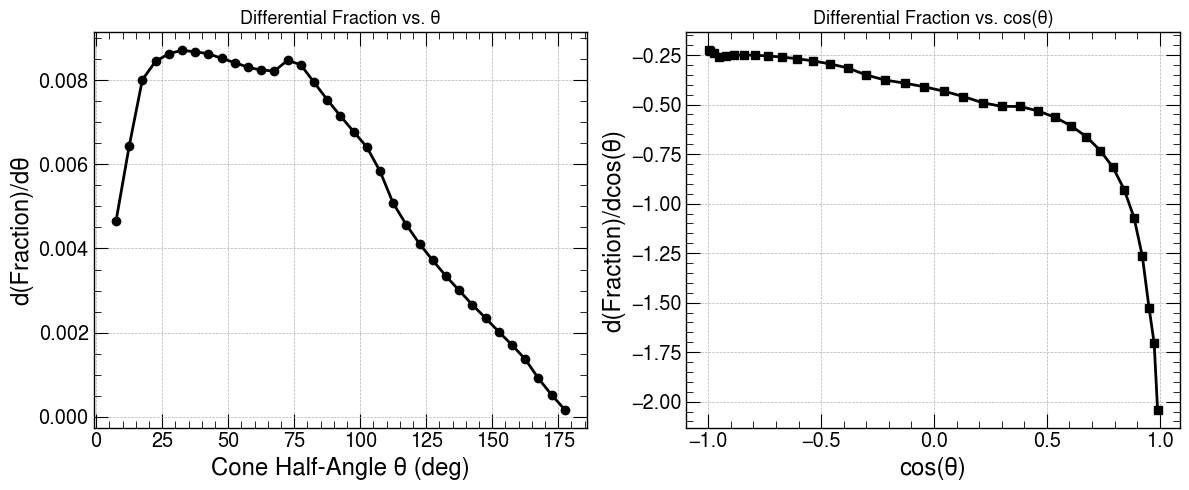

In [7]:
# Compute differentials
dtheta = np.diff(angles)
dfraction = np.diff(fractions)

# Midpoints for plotting differentials
theta_mid = 0.5 * (angles[:-1] + angles[1:])
cos_theta_mid = 0.5 * (np.cos(np.radians(angles[:-1])) + np.cos(np.radians(angles[1:])))

# Plot: dFraction/dθ vs θ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta_mid, dfraction / dtheta, marker='o')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel("d(Fraction)/dθ")
plt.title("Differential Fraction vs. θ", fontsize=13)
plt.grid(True)

# Plot: dFraction/dcos(θ) vs cos(θ)
dcos_theta = np.diff(np.cos(np.radians(angles)))
plt.subplot(1, 2, 2)
plt.plot(cos_theta_mid, dfraction / dcos_theta, marker='s')
plt.xlabel("cos(θ)")
plt.ylabel("d(Fraction)/dcos(θ)")
plt.title("Differential Fraction vs. cos(θ)", fontsize=13)
plt.grid(True)

plt.tight_layout()
plt.show()

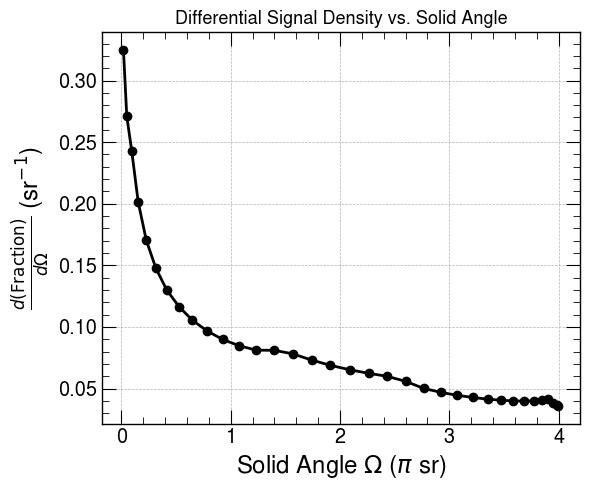

In [8]:
# Compute cumulative solid angle for each cone: Ω(θ) = 2π(1 - cosθ)
omega = 2 * np.pi * (1 - np.cos(np.radians(angles)))

# Compute differential fraction per steradian
domega = np.diff(omega)
dfraction_domega = dfraction / domega
omega_mid = 0.5 * (omega[:-1] + omega[1:])

# Convert x-axis (solid angle) to units of π steradians
omega_pi = omega_mid / np.pi

# Plot with x-axis in units of π
plt.figure(figsize=(6, 5))
plt.plot(omega_pi, dfraction_domega, marker='o')
plt.xlabel(r"Solid Angle $\Omega$ ($\pi$ sr)")
plt.ylabel(r"$\frac{d(\mathrm{Fraction})}{d\Omega}$ (sr$^{-1}$)")
plt.title("Differential Signal Density vs. Solid Angle", fontsize =13)
plt.grid(True)
plt.tight_layout()
plt.show()

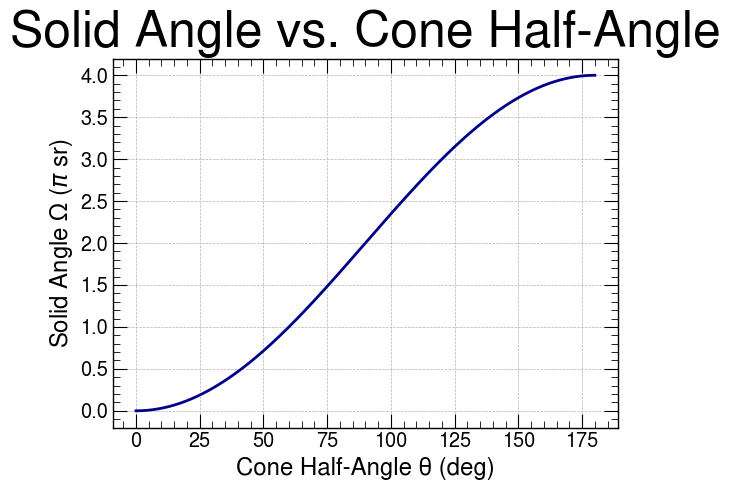

In [9]:
# Generate a fine grid of cone half-angles
theta_fine = np.linspace(0, 180, 500)  # degrees
omega_fine = 2 * np.pi * (1 - np.cos(np.radians(theta_fine)))  # sr

# Plot the theoretical relationship
plt.figure(figsize=(6, 5))
plt.plot(theta_fine, omega_fine / np.pi, color='darkblue')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel(r"Solid Angle Ω ($\pi$ sr)")
plt.title("Solid Angle vs. Cone Half-Angle")
plt.grid(True)
plt.tight_layout()
plt.show()


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_8921/3768051825.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("Solid Angle Ω ($\pi$ sr)")


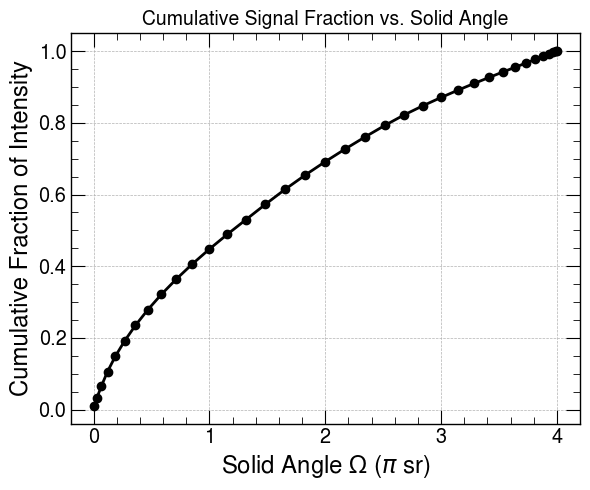

In [10]:
# Plot: cumulative fraction vs. cumulative solid angle (again for clarity)
plt.figure(figsize=(6, 5))
plt.plot(omega / np.pi, fractions, marker='o', linestyle='-')
plt.xlabel("Solid Angle Ω ($\pi$ sr)")
plt.ylabel("Cumulative Fraction of Intensity")
plt.title("Cumulative Signal Fraction vs. Solid Angle", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:

FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

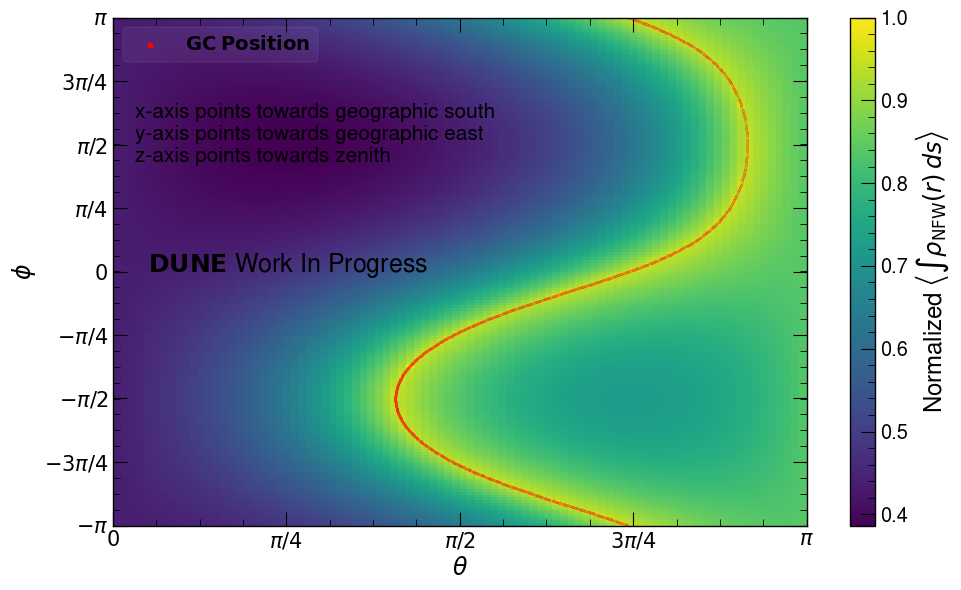

In [7]:
# Convert degrees to radians
alt_rad = np.radians(ALT_flat)
az_rad = np.radians(AZ_flat)

# Local frame: x (south), y (east), z (zenith)
x = np.cos(alt_rad) * np.sin(az_rad)
y = np.cos(alt_rad) * np.cos(az_rad)
z = np.sin(alt_rad)

# detector frame: x (drift), y (zenith), z (beam)
x_det = 0.9877*x - 0.1564*y
y_det = z
z_det = -0.1564*x-0.9877*y

# Local frame: x (south), y (east), z (zenith)
x_gc = np.cos(gc_pos[:,1]) * np.sin(gc_pos[:,0])
y_gc = np.cos(gc_pos[:,1]) * np.cos(gc_pos[:,0])
z_gc = np.sin(gc_pos[:,1])


# detector frame: x (drift), y (zenith), z (beam)
x_det_gc = 0.9877*x_gc - 0.1564*y_gc
y_det_gc = z_gc
z_det_gc = -0.1564*x_gc-0.9877*y_gc

theta_gc_det = np.arccos(z_det_gc)
phi_gc_det = np.arctan2(y_det_gc,x_det_gc)


theta_gc = np.arccos(z_gc)
phi_gc = np.arctan2(y_gc,x_gc)


# Convert to spherical coordinates
theta = np.arccos(z)              # angle from zenith [0, pi]
phi = np.arctan2(y, x)            # azimuth from south [-pi, pi]
phi = np.mod(phi, 2 * np.pi)      # shift to [0, 2pi]

# Convert to spherical coordinates in detector frame
theta_det = np.arccos(z_det)              # angle from zenith [0, pi]
phi_det = np.arctan2(y_det, x_det)            # azimuth from south [-pi, pi]

# Define bin edges
n_theta_bins = 90
n_phi_bins = 180
theta_edges = np.linspace(0, np.pi, n_theta_bins + 1)
phi_edges = np.linspace(0, 2*np.pi, n_phi_bins + 1)


# Adjust theta and phi ranges to match desired display:
# theta in [0, pi], phi in [-pi, pi] for symmetry
phi_signed = phi.copy()
phi_signed[phi_signed > np.pi] -= 2 * np.pi  # convert to range [-π, π]

# Adjust theta and phi ranges to match desired display:
# theta in [0, pi], phi in [-pi, pi] for symmetry
#phi_signed_det = phi_det.copy()
#phi_signed_det[phi_signed_det > np.pi] -= 2 * np.pi  # convert to range [-π, π]


# Create the histogram again in the same style for comparison

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

# Use the previously computed theta and phi_signed, and normalized intensity
h = ax.hist2d(theta, phi_signed, weights=intensity_sum_norm,
              bins=[theta_edges, np.linspace(-np.pi, np.pi, n_phi_bins + 1)],
               cmap='viridis')

gc_scatter = plt.scatter(theta_gc,phi_gc, marker='.', color='red', label = r'$\bf{GC\;Position}$', s =0.1)

# Axis annotation
ax.text(0.1, 1.356, "x-axis points towards geographic south\n"
                    "y-axis points towards geographic east\n"
                    "z-axis points towards zenith", fontsize=15)

# Axis labels
ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)

# X-axis ticks and labels
ax.set_xticks([0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_xticklabels([r'$0$', r'$\pi / 4$', r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize=15)

# Y-axis ticks and labels
ax.set_yticks([-3.14159, -2.356, -1.570, -0.78539, 0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$', r'$0$',
                    r'$\pi / 4$', r'$\pi / 2$', r'$3\pi / 4$', r'$\pi$'], fontsize=15)

# Add colorbar
fig.colorbar(h[3], ax=ax, label=r'Normalized $\left< \int \rho_\mathrm{NFW}(r)\, ds \right>$')
lgnd = plt.legend(handles=[gc_scatter],fontsize=14, frameon=True, framealpha=0.05)

# Fix marker size using the handles returned by legend
for handle in lgnd.legend_handles:
    handle.set_sizes([30])  # marker size in points²
    
# Optional DUNE style label
try:
    dunestyle.WIP(x=0.05, y=0.50)
except:
    pass

plt.tight_layout()
plt.show()



# Create the histogram again in the same style for comparison



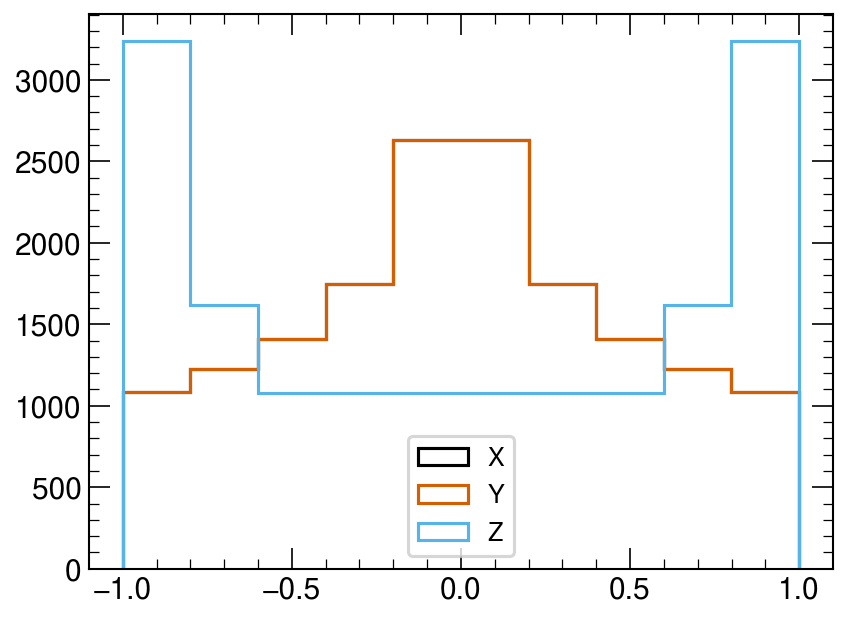

In [15]:
plt.figure(dpi=150)
plt.hist(x, histtype='step', label= 'X')
plt.hist(y, histtype='step', label= 'Y')
plt.hist(z, histtype='step', label= 'Z')
plt.legend(frameon = True)
plt.show()

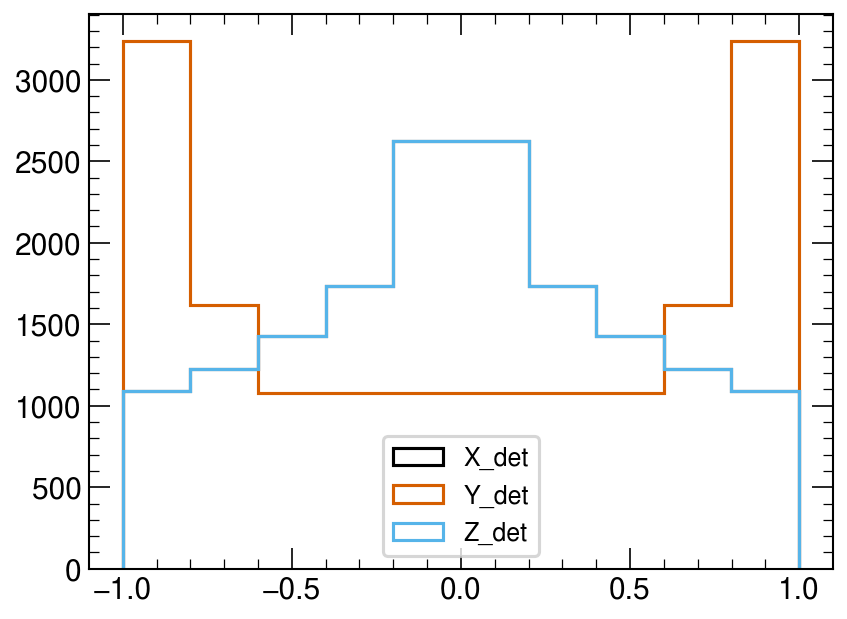

In [17]:
plt.figure(dpi=150)
plt.hist(x_det, histtype='step', label= 'X_det')
plt.hist(y_det, histtype='step', label= 'Y_det')
plt.hist(z_det, histtype='step', label= 'Z_det')
plt.legend(frameon = True)
plt.show()

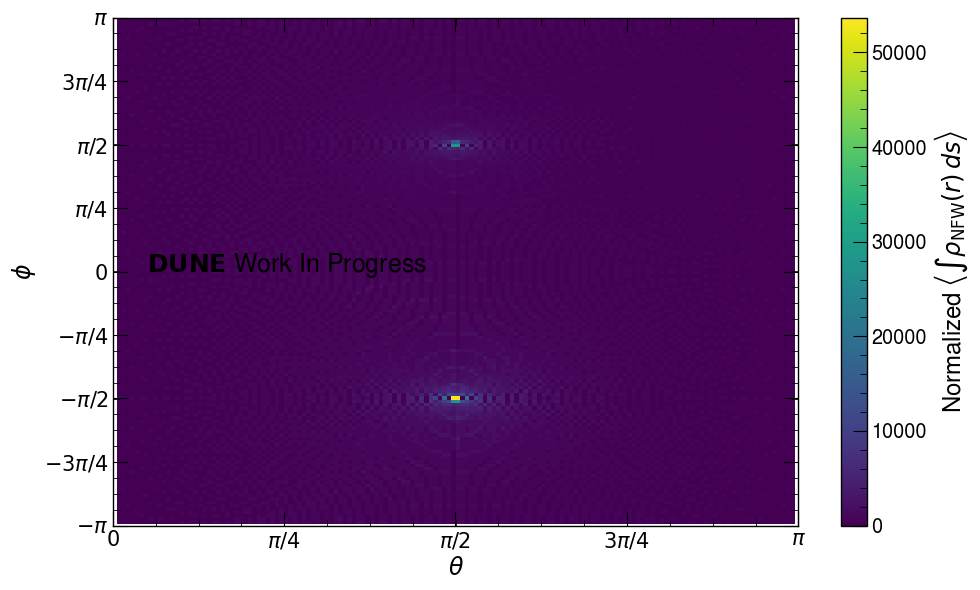

In [25]:
FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL


# Number of samples you want to generate (increase for better resolution)
n_samples = 10000000

# Normalize the weights again to make sure they sum to 1
probabilities = intensity_sum_norm / np.sum(intensity_sum_norm)

# Sample indices according to the normalized intensity
sample_indices = np.random.choice(len(theta), size=n_samples, p=probabilities)

# Use these indices to get the new theta and phi arrays
theta_new = theta[sample_indices]
phi_signed_new = phi_signed[sample_indices]


# Assuming theta and phi are numpy arrays in radians
x_geo = np.sin(theta_new) * np.cos(phi_signed_new)
y_geo = np.sin(theta_new) * np.sin(phi_signed_new)
z_geo = np.cos(theta_new)

dir_det_new = FluxRotValues.dot( np.array([x_geo,y_geo,z_geo]))

theta_det_new = np.arccos(dir_det_new[2])              # angle from zenith [0, pi]
phi_det_new = np.arctan2(dir_det_new[1], dir_det_new[0])



fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

# Use the previously computed theta and phi_signed, and normalized intensity
h = ax.hist2d(theta_det_new, phi_det_new,
              bins=[150,150],
               cmap='viridis')

#gc_scatter = plt.scatter(theta_gc_det,phi_gc_det, marker='.', color='red', label = r'$\bf{GC\;Position}$', s =0.1)


# Axis labels
ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)

# X-axis ticks and labels
ax.set_xticks([0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_xticklabels([r'$0$', r'$\pi / 4$', r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize=15)

# Y-axis ticks and labels
ax.set_yticks([-3.14159, -2.356, -1.570, -0.78539, 0.0, 0.78539, 1.570, 2.356, 3.14159])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$', r'$0$',
                    r'$\pi / 4$', r'$\pi / 2$', r'$3\pi / 4$', r'$\pi$'], fontsize=15)

# Add colorbar
fig.colorbar(h[3], ax=ax, label=r'Normalized $\left< \int \rho_\mathrm{NFW}(r)\, ds \right>$')


#lgnd = plt.legend(handles=[gc_scatter],fontsize=14, frameon=True, framealpha=0.05)

# Fix marker size using the handles returned by legend
#for handle in lgnd.legend_handles:
#    handle.set_sizes([30])  # marker size in points²
    
# Optional DUNE style label
try:
    dunestyle.WIP(x=0.05, y=0.50)
except:
    pass

plt.tight_layout()
plt.show()

/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Computing LOS integrals...


100%|██████████| 16200/16200 [00:00<00:00, 43080.12it/s]


Rotating sky into detector frame over time...


  0%|          | 0/2000 [00:00<?, ?it/s]WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary. [astropy.coordinates.builtin_frames.utils]
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/tmp/ipykernel_8921/238349271.py:66: RuntimeWarning: invalid value encountered in arccos
  theta_det = np.arccos(z_det)
100%|██████████| 2000/2000 [00:19<00:00, 102.89it/s]


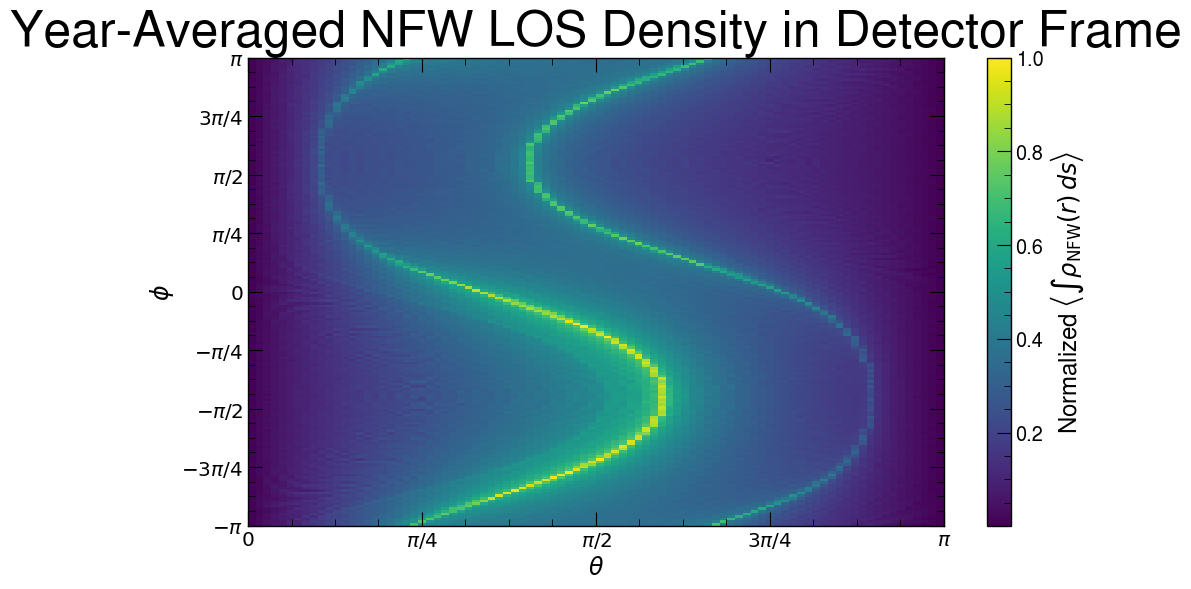

In [43]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # optional: progress bar

# --- Grid in Galactic coordinates (full sky) ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon )

b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()
coords_gal = SkyCoord(l=l_flat*u.deg, b=b_flat*u.deg, frame='galactic')

# --- Set detector location ---
location = EarthLocation(lat=43.8206*u.deg, lon=-103.7436*u.deg, height=100*u.m)

# --- Time sampling over one year ---
n_times = 2000  # increase for smoother results
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

# --- Bin edges for histogram ---
n_theta_bins = 90
n_phi_bins = 180
theta_edges = np.linspace(0, np.pi, n_theta_bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, n_phi_bins + 1)

# --- Accumulator for histogram counts ---
accum_weights = np.zeros((n_phi_bins, n_theta_bins))

# --- Precompute LOS integrals once (doesn't depend on time) ---
print("Computing LOS integrals...")
rho_vals = np.array([los_integral(l, b) for l, b in tqdm(zip(l_flat, b_flat), total=len(l_flat))])
rho_vals /= np.max(rho_vals)  # normalize

# --- Loop over time to accumulate intensity maps ---
print("Rotating sky into detector frame over time...")
for time in tqdm(times):
    # Convert to AltAz frame
    coords_altaz = coords_gal.transform_to(AltAz(obstime=time, location=location))
    alt_rad = coords_altaz.alt.radian
    az_rad = coords_altaz.az.radian

    # Convert to local frame Cartesian
    x = np.cos(alt_rad) * np.sin(az_rad)
    y = np.cos(alt_rad) * np.cos(az_rad)
    z = np.sin(alt_rad)
    arr_local = np.stack([x, y, z], axis=0)

    # Rotate to detector frame
    arr_det = FluxRotValues @ arr_local
    x_det, y_det, z_det = arr_det
    theta_det = np.arccos(z_det)
    phi_det = np.arctan2(y_det, x_det)
    #phi_det = np.mod(phi_det, 2 * np.pi)      # shift to [0, 2pi]
    phi_det[phi_det > np.pi] -= 2 * np.pi

    # Accumulate histogram with LOS weights
    H, _, _ = np.histogram2d(phi_det, theta_det,
                             bins=[phi_edges, theta_edges],
                             weights=rho_vals)
    accum_weights += H

# --- Normalize the accumulated map ---
accum_weights /= np.max(accum_weights)



# --- Plot result ---
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
mesh = ax.pcolormesh(theta_edges, phi_edges, accum_weights, cmap='viridis', shading='auto')

ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)
ax.set_title("Year-Averaged NFW LOS Density in Detector Frame")

# Tick labels
ax.set_xticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

ax.set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', r'$0$', r'$\pi/4$',
                    r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

fig.colorbar(mesh, ax=ax, label=r'Normalized $\left< \int \rho_{\rm NFW}(r)\, ds \right>$')
plt.tight_layout()
plt.show()


In [ ]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # optional: progress bar

# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)


# --- Grid in Galactic coordinates (full sky) ---
n_lat = 90
n_lon = 180
l_vals = np.linspace(0, 360, n_lon )

b_vals = np.linspace(-90, 90, n_lat)
L, B = np.meshgrid(l_vals, b_vals)
l_flat = L.flatten()
b_flat = B.flatten()
coords_gal = SkyCoord(l=l_flat*u.deg, b=b_flat*u.deg, frame='galactic')

# --- Set detector location ---
location = EarthLocation(lat=43.8206*u.deg, lon=-103.7436*u.deg, height=100*u.m)

# --- Time sampling over one year ---
n_times = 2000  # increase for smoother results
start_time = Time("2030-01-01 00:00:00")
end_time = start_time + 1 * u.year
times = Time(np.linspace(start_time.jd, end_time.jd, n_times), format='jd')

# --- Detector rotation matrix (AltAz → Detector frame) ---
FluxRotValues = np.array([
    [+0.9877, -0.1564, +0.0000],
    [+0.0000, +0.0000, +1.0000],
    [-0.1564, -0.9877, +0.0000]
])

# --- Bin edges for histogram ---
n_theta_bins = 90
n_phi_bins = 180
theta_edges = np.linspace(0, np.pi, n_theta_bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, n_phi_bins + 1)

# --- Accumulator for histogram counts ---
accum_weights = np.zeros((n_phi_bins, n_theta_bins))

# --- Precompute LOS integrals once (doesn't depend on time) ---
print("Computing LOS integrals...")
rho_vals = np.array([los_integral(l, b) for l, b in tqdm(zip(l_flat, b_flat), total=len(l_flat))])
rho_vals /= np.max(rho_vals)  # normalize

# --- Loop over time to accumulate intensity maps ---
print("Rotating sky into detector frame over time...")
for time in tqdm(times):
    # Convert to AltAz frame
    coords_altaz = coords_gal.transform_to(AltAz(obstime=time, location=location))
    alt_rad = coords_altaz.alt.radian
    az_rad = coords_altaz.az.radian

    # Convert to local frame Cartesian
    x = np.cos(alt_rad) * np.sin(az_rad)
    y = np.cos(alt_rad) * np.cos(az_rad)
    z = np.sin(alt_rad)
    arr_local = np.stack([x, y, z], axis=0)

    # Rotate to detector frame
    arr_det = FluxRotValues @ arr_local
    x_det, y_det, z_det = arr_det
    theta_det = np.arccos(z_det)
    phi_det = np.arctan2(y_det, x_det)
    #phi_det = np.mod(phi_det, 2 * np.pi)      # shift to [0, 2pi]
    phi_det[phi_det > np.pi] -= 2 * np.pi

    # Accumulate histogram with LOS weights
    H, _, _ = np.histogram2d(phi_det, theta_det,
                             bins=[phi_edges, theta_edges],
                             weights=rho_vals)
    accum_weights += H

# --- Normalize the accumulated map ---
accum_weights /= np.max(accum_weights)



# --- Plot result ---
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
mesh = ax.pcolormesh(theta_edges, phi_edges, accum_weights, cmap='viridis', shading='auto')

ax.set_xlabel(r'$\theta$', fontsize=17)
ax.set_ylabel(r'$\phi$', fontsize=17)
ax.set_title("Year-Averaged NFW LOS Density in Detector Frame")

# Tick labels
ax.set_xticks([0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

ax.set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_yticklabels([r'$-\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', r'$0$', r'$\pi/4$',
                    r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

fig.colorbar(mesh, ax=ax, label=r'Normalized $\left< \int \rho_{\rm NFW}(r)\, ds \right>$')
plt.tight_layout()
plt.show()
